##Problem Statement
[Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) refers to the task of finding/identifying rare events/data points. Some applications include - bank fraud detection, tumor detection in medical imaging, and errors in written text.
A lot of supervised and unsupervised approaches to anomaly detection has been proposed. Some of the approaches include - One-class SVMs, Bayesian Networks, Cluster analysis, and (of course) Neural Networks.

We will use an Autoencoder Neural Network to detect/predict anomalies in ECG

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Data: The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

In [3]:
df = pd.read_csv('ecg_final.txt', sep = '  ', header = None, engine = 'python')
df.columns

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
           dtype='int64', length=141)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            131, 132, 133, 134, 135, 136, 137, 138, 139, 140],
           dtype='int64', length=141)

In [4]:
df[0].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: 0, dtype: int64

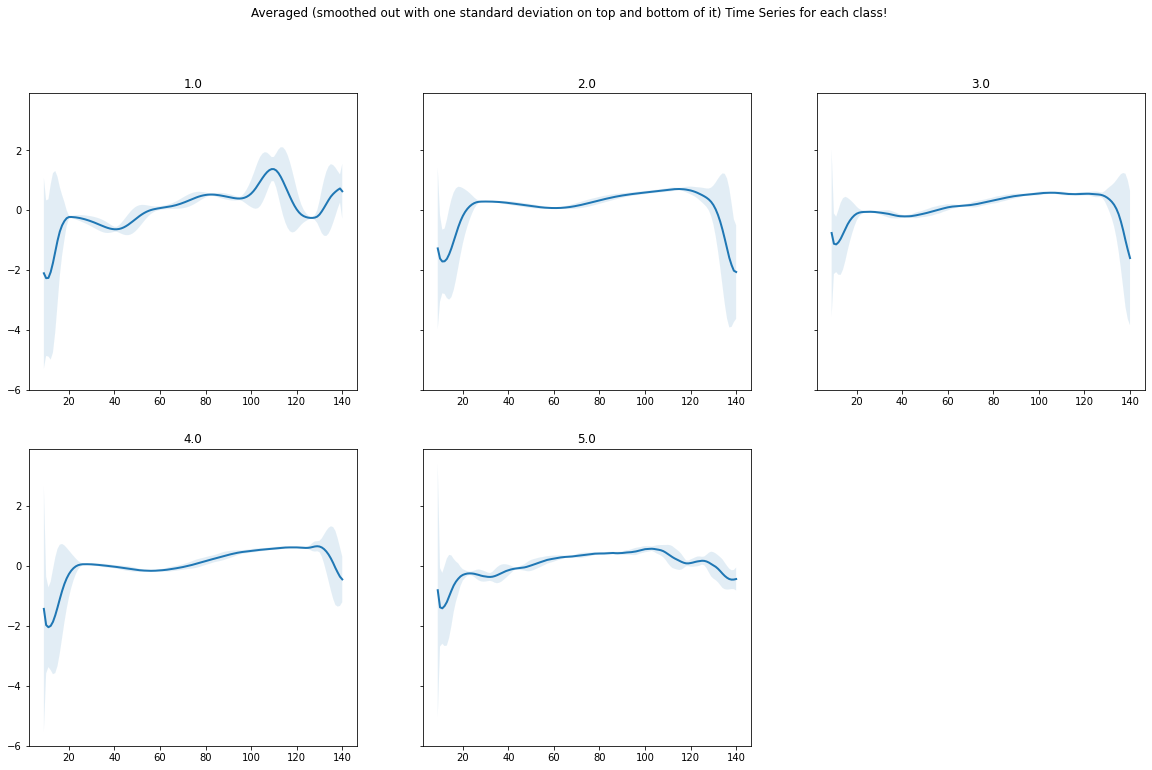

In [5]:
def visualise(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

classes = df[0].unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(20, 12)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df[0] == cls] \
    .mean(axis=0) \
    .to_numpy()
  visualise(data, classes[i], ax)

fig.delaxes(axs.flat[-1])
fig.suptitle('Averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class!')
fig.show()

*class 1 is the normal activity, 2 to 5 are the abnormal activity or anomaly.
The normal class, the normal class has the distinctly different patterns than other patterns and has by far, the most examples. This is great because we’ll use it to train our model.*

In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.527400,-0.262476,-1.649511,-2.492211,-3.119443,-3.167438,-2.866308,-2.273126,-1.798127,-1.410124,...,0.146319,0.070973,-0.062914,-0.276206,-0.507667,-0.761043,-0.834741,-0.642263,-0.487242,-0.706008
std,0.760372,1.152369,1.445493,1.386409,1.302802,1.104382,0.906133,0.731627,0.623100,0.637149,...,1.171299,1.404842,1.646585,1.895134,2.059758,2.086218,2.056220,1.859296,1.830987,1.414465
min,1.000000,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,...,-3.971715,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227
25%,1.000000,-1.004511,-2.701576,-3.668096,-4.227247,-4.007470,-3.480479,-2.779941,-2.165851,-1.774124,...,-0.655753,-1.089300,-1.588885,-2.147449,-2.731550,-3.030509,-2.868331,-2.153513,-1.657771,-1.596692
50%,1.000000,-0.297541,-1.661892,-2.585677,-3.387934,-3.468718,-2.947061,-2.285578,-1.750157,-1.422570,...,0.473642,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.565588
75%,2.000000,0.500061,-0.677290,-1.513964,-2.235369,-2.530967,-2.398813,-1.823494,-1.484923,-1.063708,...,1.062134,1.169420,1.238687,1.264471,1.234433,1.034584,0.945237,0.951681,1.002692,0.272012
max,5.000000,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,...,2.960969,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103


Let's scale, get all normal heartbeats (class 1) and drop the class column. We will be mearging all the other classes as one anomaly class.

In [7]:
train_x, test_x, train_y, test_y = train_test_split(
    df.values, df.values[:, 0:1], test_size = 0.1, random_state = 42
    )

In [8]:
scaler = MinMaxScaler()
data_scaled = scaler.fit(train_x)

In [9]:
train_x_scaled = data_scaled.transform(train_x)
test_x_scaled = data_scaled.transform(test_x)

In [10]:
normal_train_x = pd.DataFrame(train_x_scaled).add_prefix('c').query('c0 == 0').values[:, 1:]
normal_test_x = pd.DataFrame(test_x_scaled).add_prefix('c').query('c0 == 0').values[:, 1:]
anomaly_test_x = pd.DataFrame(test_x_scaled).append(pd.DataFrame(train_x_scaled)).add_prefix('c').query('c0 != 0').values[:, 1:]

df.values.shape, normal_train_x.shape, normal_test_x.shape, anomaly_test_x.shape

((5000, 141), (2610, 140), (309, 140), (2081, 140))





## > 🏗        **Building the Model (AutoEncoder)**

---

[Autoencoders Neural Networks](https://en.wikipedia.org/wiki/Autoencoder) try to learn data representation of its input. So the input of the Autoencoder is the same as the output? Not quite. Usually, we want to learn an efficient encoding that uses fewer parameters/memory.
The encoding should allow for output similar to the original input. In a sense, we’re forcing the model to learn the most important features of the data using as few parameters as possible.

Here are the basic steps to Anomaly Detection using an Autoencoder:
1. Train an Autoencoder on normal data (no anomalies)
2. Take a new data point and try to reconstruct it using the Autoencoder
3. If the error (reconstruction error) for the new data point is above some threshold, we label the
example as an anomaly
---





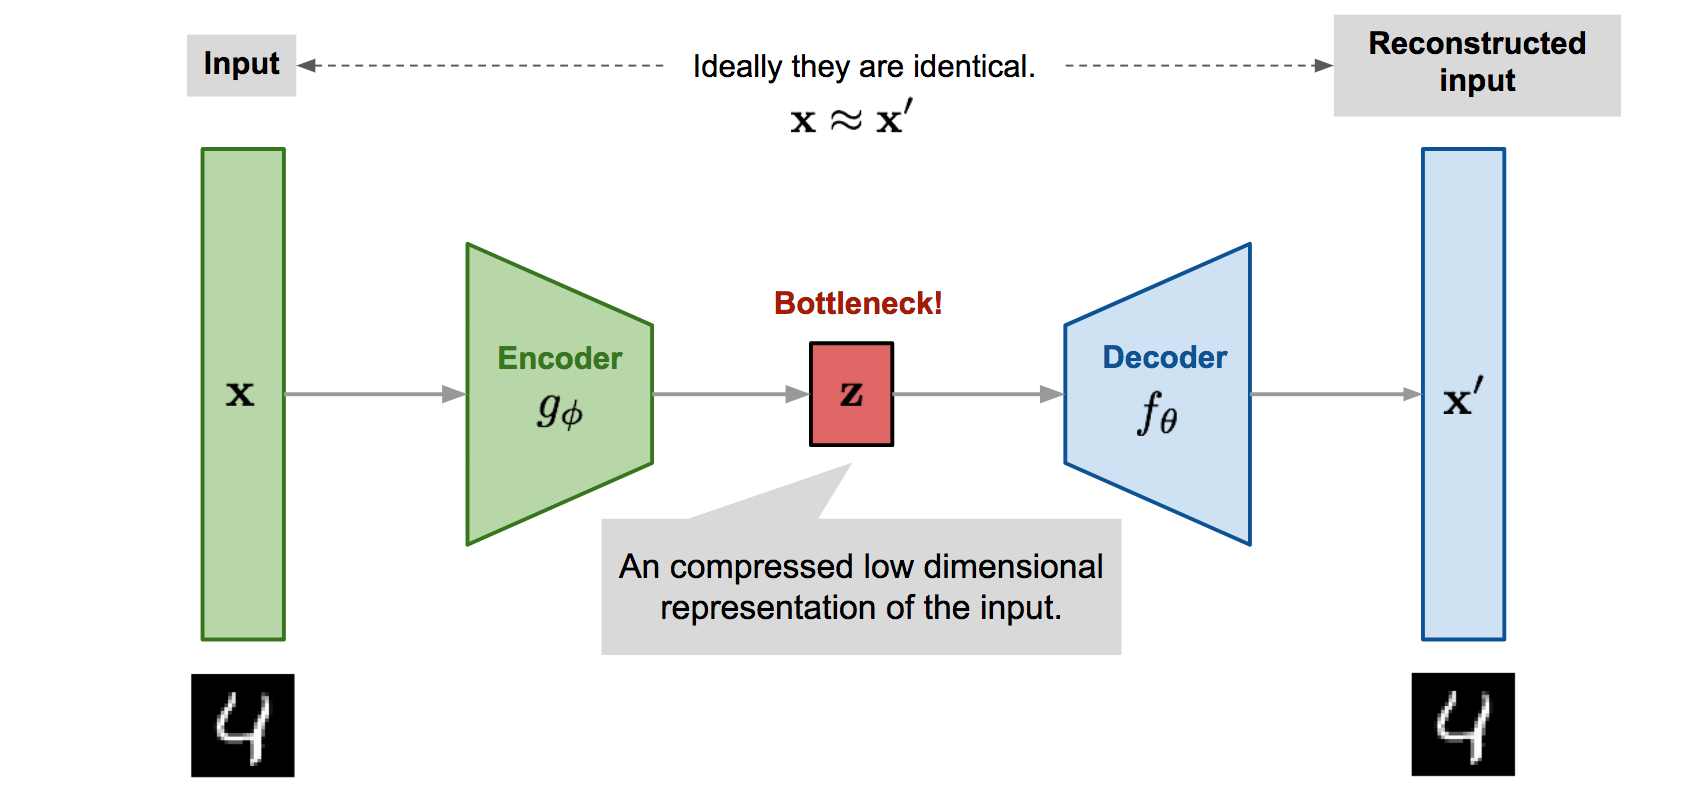

In [11]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential(
            [   
                tf.keras.layers.Input(shape=(140, )),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(8, activation='relu')
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(16, activation='relu'),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(140, activation='sigmoid')
            ]
        )
      
    def call(self, x):
        return self.decoder(self.encoder(x))

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min'
)

In [13]:
model = AutoEncoder()
model.compile(optimizer='adam', loss='mae', metrics=['accuracy'])

In [14]:
history = model.fit(
    normal_train_x,
    normal_train_x,
    epochs=50,
    batch_size=128,
    validation_data=(normal_train_x, normal_train_x,),
    shuffle=True,
)

Epoch 1/50
21/21 [==============================] - 4s 14ms/step - loss: 0.1090 - accuracy: 0.0015 - val_loss: 0.0709 - val_accuracy: 0.0218
Epoch 2/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0555 - accuracy: 0.1100 - val_loss: 0.0471 - val_accuracy: 0.2157
Epoch 3/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0456 - accuracy: 0.2157 - val_loss: 0.0449 - val_accuracy: 0.2157
Epoch 4/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0448 - accuracy: 0.2157 - val_loss: 0.0447 - val_accuracy: 0.2157
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.2157 - val_loss: 0.0445 - val_accuracy: 0.2157
Epoch 6/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0445 - accuracy: 0.2157 - val_loss: 0.0443 - val_accuracy: 0.2157
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.0443 - accuracy: 0.2157 - val_loss: 0.0442 - val_accuracy: 0.2157
Epoch 8/50
21/21 [=

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 11768     
                                                                 
 sequential_1 (Sequential)   (None, 140)               11900     
                                                                 
Total params: 23,668
Trainable params: 23,668
Non-trainable params: 0
_________________________________________________________________


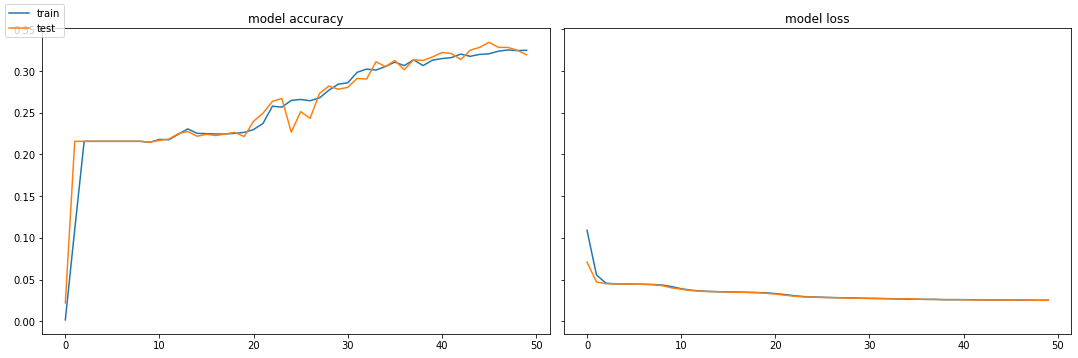

In [15]:
fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  figsize=(15, 5)
)

# summarize history for accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

fig.legend(['train', 'test'], loc='upper left')
fig.tight_layout()

model.summary()

Latent Space Visualization

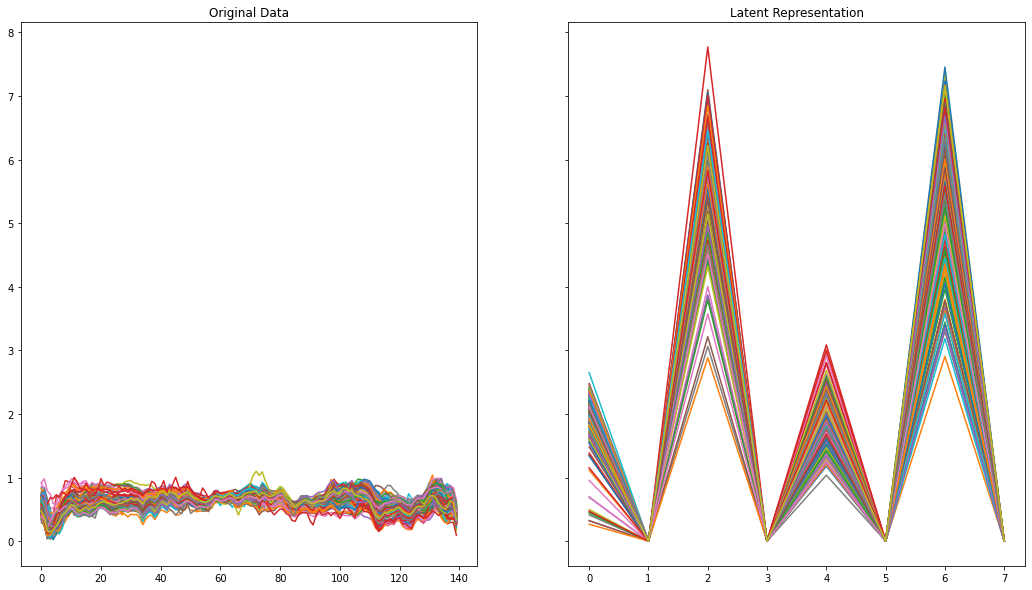

In [16]:


encoded_images = model.encoder(normal_test_x)

fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  figsize=(18, 10)
)

for i in range(encoded_images.shape[0]):
    ax = axs.flat[0]
    ax1 = axs.flat[1]
    ax1.plot(encoded_images[i])
    ax.plot(normal_test_x[i])

ax.set_title("Original Data")
ax1.set_title("Latent Representation")
fig.show()

Reconstructing(inference) Normal 

In [17]:
normal_test_infer = model.predict(normal_test_x)
normal_train_infer =  model.predict(normal_train_x)

In [18]:
normal_test_infer.shape, normal_train_infer.shape

((309, 140), (2610, 140))

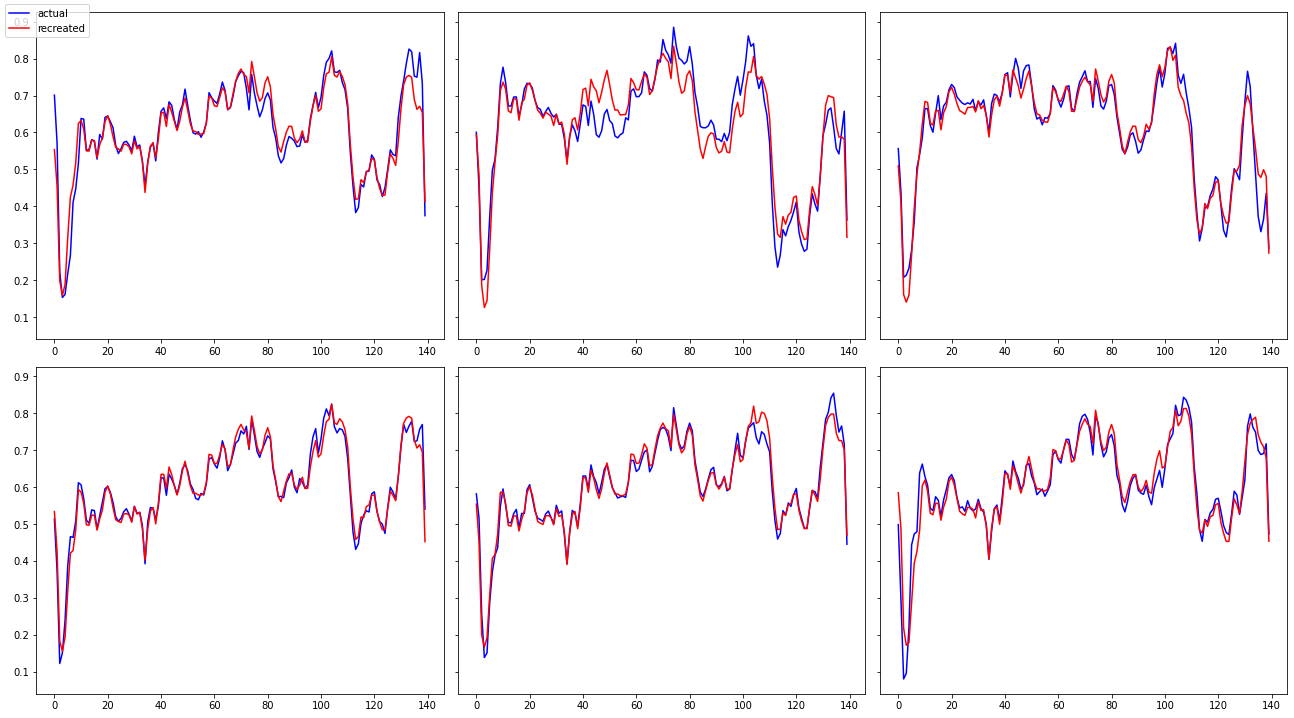

In [19]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=3,
  sharey=True,
  figsize=(18, 10)
)

for i  in range(3):
  ax = axs.flat[i]
  ax.plot(normal_test_x[i*5], 'b')
  ax.plot(normal_test_infer[i*5], 'r')

for i  in range(3):
  ax = axs.flat[i+3]
  ax.plot(normal_train_x[i*5], 'b')
  ax.plot(normal_train_infer[i*5], 'r')

fig.legend(['actual', 'recreated'], loc='upper left')
fig.tight_layout()
fig.show()

(2081, 140)


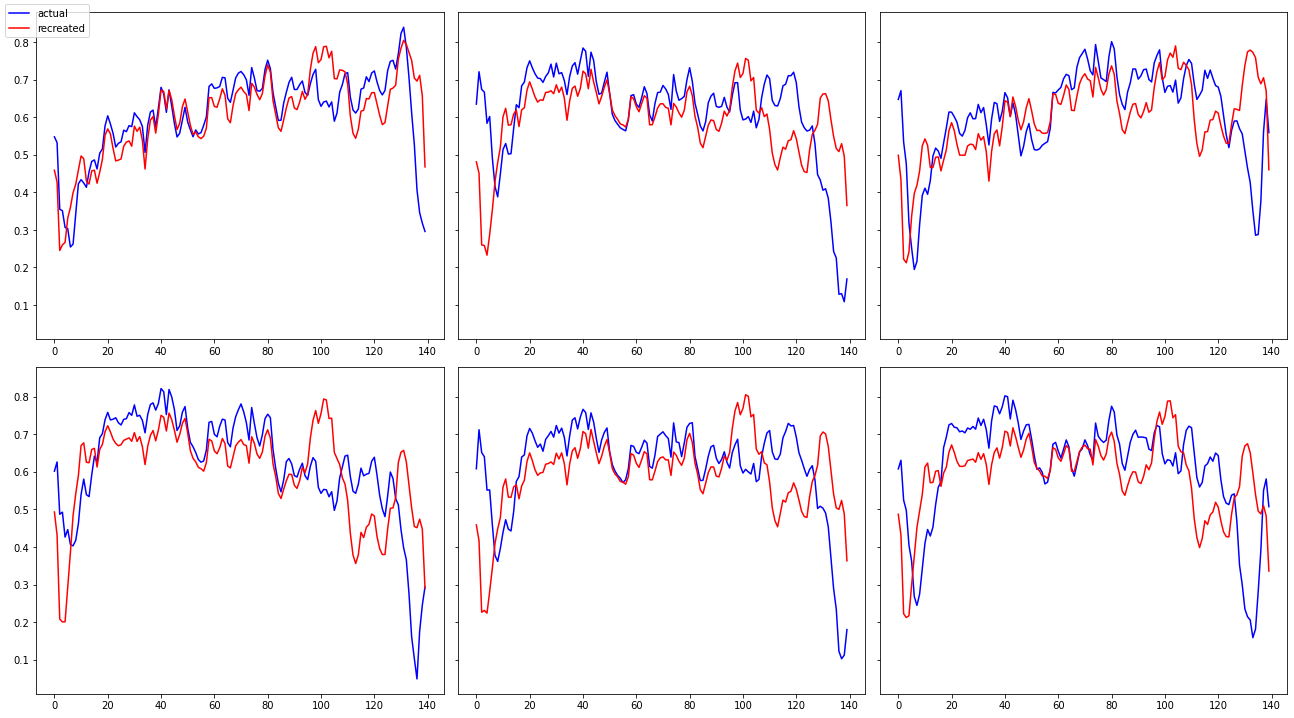

In [20]:
anomaly_test_infer = model.predict(anomaly_test_x)
print(anomaly_test_infer.shape)

fig, axs = plt.subplots(
  nrows=2,
  ncols=3,
  sharey=True,
  figsize=(18, 10)
)

for i  in range(6):
  ax = axs.flat[i]
  ax.plot(anomaly_test_x[i*5], 'b')
  ax.plot(anomaly_test_infer[i*5], 'r')

fig.legend(['actual', 'recreated'], loc='upper left')
fig.tight_layout()
fig.show()

**Computing Construction Loss (For both Class)**

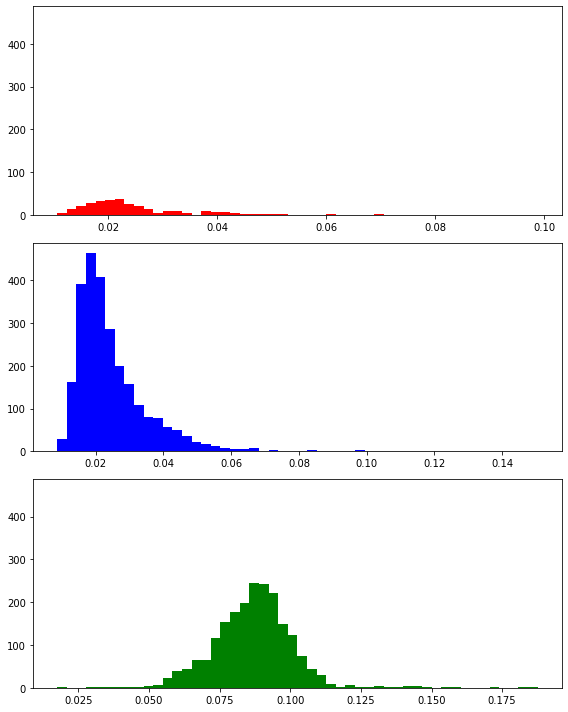

In [21]:
normal_test_loss = tf.keras.losses.mae(normal_test_infer, normal_test_x)
normal_train_loss = tf.keras.losses.mae(normal_train_infer, normal_train_x)

anomaly_test_loss = tf.keras.losses.mae(anomaly_test_infer, anomaly_test_x)

fig, axs = plt.subplots(
  nrows=3,
  ncols=1,
  sharey=True,
  figsize=(8, 10)
)

axs.flat[0].hist(normal_test_loss, color='r', bins=50)
axs.flat[1].hist(normal_train_loss, color='b', bins=50)
axs.flat[2].hist(anomaly_test_loss, color='g', bins=50)
fig.tight_layout()
fig.show()

**Determining Threshold**

In [22]:
threshold = round(np.mean(normal_test_loss) + 2.2*np.std(normal_test_loss), 3)
np.mean(normal_test_loss), np.std(normal_test_loss), threshold

(0.02526924854312832, 0.01111358137599704, 0.05)

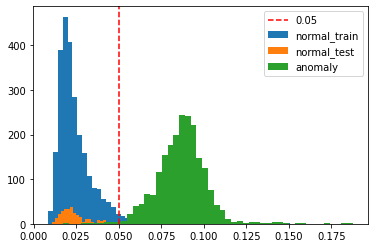

In [23]:
plt.hist(normal_train_loss, bins=50, label = 'normal_train')
plt.hist(normal_test_loss, bins=50, label = 'normal_test')
plt.hist(anomaly_test_loss, bins=50, label = 'anomaly')
plt.axvline(threshold, color = 'r', label=f'{threshold}', linestyle = 'dashed')
plt.legend(loc = 'upper right')
plt.show()

**Evaluating The Final Classification**

In [24]:
normal_test_preds = tf.math.less(normal_test_loss, threshold)
print("Correct Normal Test  :", end=' ')
print(tf.math.count_nonzero(normal_test_preds).numpy(), '/' ,normal_test_x.shape[0], end = ' ', sep='')
print(f"  ({tf.math.count_nonzero(normal_test_preds).numpy() / normal_test_x.shape[0] * 100} %)")


normal_train_preds = tf.math.less(normal_train_loss, threshold)
print("Correct Normal Train :", end=' ')
print(tf.math.count_nonzero(normal_train_preds).numpy(), '/' ,normal_train_x.shape[0], end = ' ', sep='')
print(f"({tf.math.count_nonzero(normal_train_preds).numpy() / normal_train_x.shape[0] * 100} %)")

anomaly_test_preds = tf.math.greater(anomaly_test_loss, threshold)
print("Correct Anomaly Test :", end=' ')
print(tf.math.count_nonzero(anomaly_test_preds).numpy(), '/' ,anomaly_test_x.shape[0], end = ' ', sep='')
print(f"({tf.math.count_nonzero(anomaly_test_preds).numpy() / anomaly_test_x.shape[0] * 100} %)")

Correct Normal Test  : 297/309   (96.11650485436894 %)
Correct Normal Train : 2516/2610 (96.3984674329502 %)
Correct Anomaly Test : 2064/2081 (99.18308505526188 %)




---


**Improvement Suggestion**

We are already getting good results, but we may be able to imrove our accuracy more by employing the following strategy.

i.e; Prepare an autoencoder for all the 5 classes and classify an instance according to lowest construction error value.



---






In [25]:
# model is already trained on normal class (class 0)
model1 = AutoEncoder()
model2 = AutoEncoder()
model3 = AutoEncoder()
model4 = AutoEncoder()

train_x, test_x, train_y, test_y = train_test_split(
    df.values, df.values[:, 0:1], test_size = 0.1, random_state = 42
    )

train_x_df = pd.DataFrame(train_x)

# now we will extract data for each class and train their respective model
train_x_1 = data_scaled.transform(train_x_df.add_prefix('c').query('c0 == 2').values)[:, 1:]
train_x_2 = data_scaled.transform(train_x_df.add_prefix('c').query('c0 == 3').values)[:, 1:]
train_x_3 = data_scaled.transform(train_x_df.add_prefix('c').query('c0 == 4').values)[:, 1:]
train_x_4 = data_scaled.transform(train_x_df.add_prefix('c').query('c0 == 5').values)[:, 1:]

train_x_1.shape, train_x_2.shape, train_x_3.shape, train_x_4.shape

((1607, 140), (85, 140), (178, 140), (20, 140))

Epoch 1/50
13/13 [==============================] - 1s 20ms/step - loss: 0.1500 - accuracy: 6.2228e-04 - val_loss: 0.1296 - val_accuracy: 6.2228e-04
Epoch 2/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1051 - accuracy: 6.2228e-04 - val_loss: 0.0787 - val_accuracy: 6.2228e-04
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0648 - accuracy: 0.0162 - val_loss: 0.0532 - val_accuracy: 0.0423
Epoch 4/50
13/13 [==============================] - 0s 6ms/step - loss: 0.0503 - accuracy: 0.0423 - val_loss: 0.0481 - val_accuracy: 0.0423
Epoch 5/50
13/13 [==============================] - 0s 9ms/step - loss: 0.0472 - accuracy: 0.1942 - val_loss: 0.0464 - val_accuracy: 0.4692
Epoch 6/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0460 - accuracy: 0.4692 - val_loss: 0.0456 - val_accuracy: 0.4692
Epoch 7/50
13/13 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.4692 - val_loss: 0.0448 - val_accuracy: 0.4692
Ep

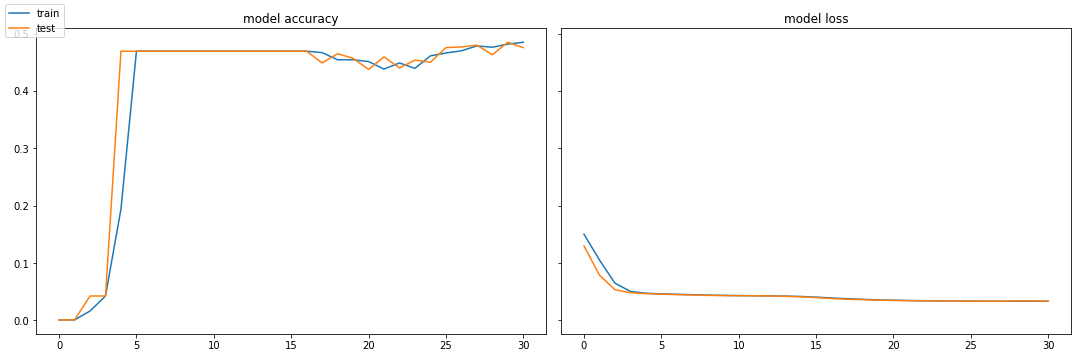

In [26]:
#Compile and train each model
model1.compile(optimizer='adam', loss='mae', metrics=['accuracy'])
history = model1.fit(
    train_x_1,
    train_x_1,
    epochs=50,
    batch_size=128,
    validation_data=(train_x_1, train_x_1),
    shuffle=True,
    callbacks=[early_stopping]
)

fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  figsize=(15, 5)
)

# summarize history for accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

fig.legend(['train', 'test'], loc='upper left')
fig.tight_layout()

Epoch 1/50
1/1 [==============================] - 1s 956ms/step - loss: 0.0693 - accuracy: 0.1882 - val_loss: 0.0692 - val_accuracy: 0.1882
Epoch 2/50
1/1 [==============================] - 0s 55ms/step - loss: 0.0692 - accuracy: 0.1882 - val_loss: 0.0692 - val_accuracy: 0.1882
Epoch 3/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0692 - accuracy: 0.1882 - val_loss: 0.0692 - val_accuracy: 0.1882
Epoch 4/50
1/1 [==============================] - 0s 54ms/step - loss: 0.0692 - accuracy: 0.1882 - val_loss: 0.0691 - val_accuracy: 0.1882
Epoch 5/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0691 - accuracy: 0.1882 - val_loss: 0.0691 - val_accuracy: 0.1882
Epoch 6/50
1/1 [==============================] - 0s 58ms/step - loss: 0.0691 - accuracy: 0.1882 - val_loss: 0.0691 - val_accuracy: 0.2000
Epoch 7/50
1/1 [==============================] - 0s 61ms/step - loss: 0.0691 - accuracy: 0.2000 - val_loss: 0.0690 - val_accuracy: 0.2000
Epoch 8/50
1/1 [==========

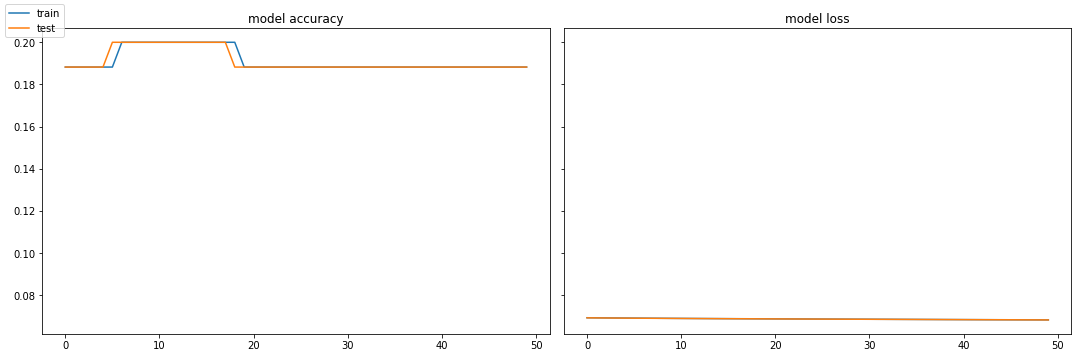

In [27]:
#Compile and train each model
model1.compile(optimizer='sgd', loss='mae', metrics=['accuracy'])
history = model1.fit(
    train_x_2,
    train_x_2,
    epochs=50,
    batch_size=128,
    validation_data=(train_x_2, train_x_2),
    shuffle=True,
    callbacks=[early_stopping]
)

fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  figsize=(15, 5)
)

# summarize history for accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

fig.legend(['train', 'test'], loc='upper left')
fig.tight_layout()

Epoch 1/50
2/2 [==============================] - 1s 186ms/step - loss: 0.0531 - accuracy: 0.2303 - val_loss: 0.0530 - val_accuracy: 0.2303
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0530 - accuracy: 0.2303 - val_loss: 0.0529 - val_accuracy: 0.2303
Epoch 3/50
2/2 [==============================] - 0s 28ms/step - loss: 0.0529 - accuracy: 0.2303 - val_loss: 0.0529 - val_accuracy: 0.2303
Epoch 4/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0529 - accuracy: 0.2303 - val_loss: 0.0528 - val_accuracy: 0.2303
Epoch 5/50
2/2 [==============================] - 0s 25ms/step - loss: 0.0528 - accuracy: 0.2303 - val_loss: 0.0528 - val_accuracy: 0.2303
Epoch 6/50
2/2 [==============================] - 0s 29ms/step - loss: 0.0528 - accuracy: 0.2303 - val_loss: 0.0527 - val_accuracy: 0.2303
Epoch 7/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0527 - accuracy: 0.2303 - val_loss: 0.0527 - val_accuracy: 0.2303
Epoch 8/50
2/2 [==========

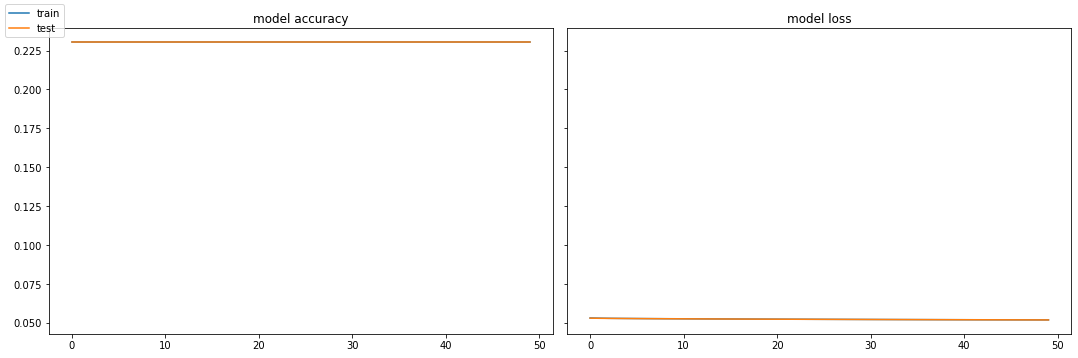

In [28]:
#Compile and train each model
model1.compile(optimizer='sgd', loss='mae', metrics=['accuracy'])
history = model1.fit(
    train_x_3,
    train_x_3,
    epochs=50,
    batch_size=128,
    validation_data=(train_x_3, train_x_3),
    shuffle=True,
    callbacks=[early_stopping]
)

fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  figsize=(15, 5)
)

# summarize history for accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

fig.legend(['train', 'test'], loc='upper left')
fig.tight_layout()

Epoch 1/50
1/1 [==============================] - 1s 562ms/step - loss: 0.1010 - accuracy: 0.0000e+00 - val_loss: 0.1009 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1009 - accuracy: 0.0000e+00 - val_loss: 0.1009 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1009 - accuracy: 0.0000e+00 - val_loss: 0.1009 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 28ms/step - loss: 0.1009 - accuracy: 0.0000e+00 - val_loss: 0.1008 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 0.1008 - accuracy: 0.0000e+00 - val_loss: 0.1008 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1008 - accuracy: 0.0000e+00 - val_loss: 0.1008 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1008 - accuracy: 0.0000e+00 - val_loss: 0.10

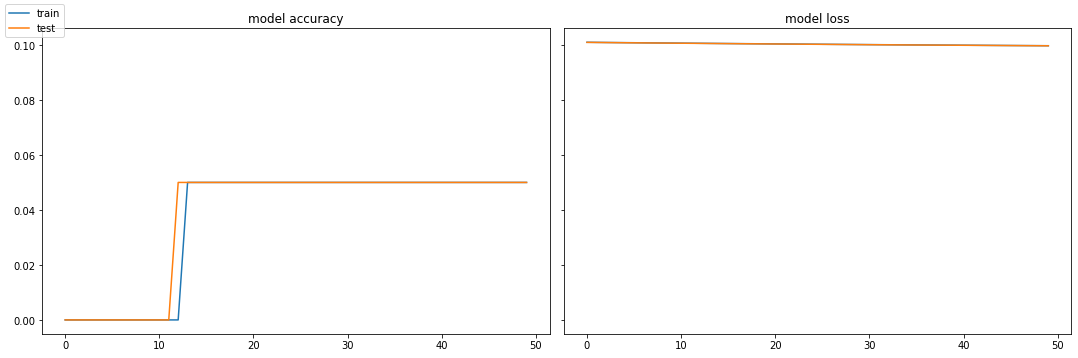

In [29]:
#Compile and train each model
model1.compile(optimizer='sgd', loss='mae', metrics=['accuracy'])
history = model1.fit(
    train_x_4,
    train_x_4,
    epochs=50,
    batch_size=128,
    validation_data=(train_x_4, train_x_4),
    shuffle=True,
    callbacks=[early_stopping]
)

fig, axs = plt.subplots(
  nrows=1,
  ncols=2,
  sharey=True,
  figsize=(15, 5)
)

# summarize history for accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('model accuracy')

# summarize history for loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('model loss')

fig.legend(['train', 'test'], loc='upper left')
fig.tight_layout()

In [30]:
#inference and classification
labels = df.values[:,:1]

data = data_scaled.transform(df.values)[:,1:]

model_infer_loss  = tf.keras.losses.mae(model.predict(data), data)
model1_infer_loss = tf.keras.losses.mae(model1.predict(data), data)
model2_infer_loss = tf.keras.losses.mae(model2.predict(data), data)
model3_infer_loss = tf.keras.losses.mae(model3.predict(data), data)
model4_infer_loss = tf.keras.losses.mae(model4.predict(data), data)

pred = np.ones((data.shape[0], 1), dtype = bool)
for i in range(data.shape[0]):
  pred[i] = model_infer_loss[i] < min(model1_infer_loss[i], model2_infer_loss[i], model3_infer_loss[i], model4_infer_loss[i])



In [31]:
print(round(np.count_nonzero((labels == 1) == pred) / pred.shape[0] * 100, 2), "% Accuracy", sep="")

97.34% Accuracy




---


**Another Improvement Suggestion**

We have seen a little improvement by employing the previous strategy but we still have little room for improvement. (Little accuracy error in the previous iteration may be attributed to less data for some of the classes proving insufficient for respective encoders to generalize well hence resulting in some of the wrong classifications we observe an obvious approach to remedy that would be to increase data for the said classes but we will leave that for another day).





---




